In [1]:
#%matplotlib inline

import xarray as xr
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import animation as anim
from datetime import datetime, timedelta
from osgeo import gdal
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
path_base = '/g/data/rr5/satellite/obs/himawari8/FLDK/'

band_suffix = np.array(['-P1S-ABOM_OBS_B01-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc',
                       '-P1S-ABOM_OBS_B02-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc',
                       '-P1S-ABOM_OBS_B03-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc',
                       '-P1S-ABOM_OBS_B08-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc',
                       '-P1S-ABOM_OBS_B13-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc',
                       '-P1S-ABOM_OBS_B14-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc',
                       '-P1S-ABOM_OBS_B15-PRJ_GEOS141_2000-HIMAWARI8-AHI.nc'])

In [4]:
s_time = datetime(2019,6,8,0,0,0) -timedelta(hours=10)
e_time = datetime(2019,6,9,23,0,0) -timedelta(hours=10)

#s_time = datetime(2019,6,2,0,0,0)
#e_time = datetime(2019,6,12,0,0,0)

space_minutes = 60

dif_minutes= (e_time - s_time)
print(dif_minutes.seconds)
dif_minutes= dif_minutes.total_seconds()/60

t_range = np.arange(dif_minutes/space_minutes + 1)
print(t_range)
dates = np.array([s_time + timedelta(minutes=space_minutes*i) for i in t_range])
dif_minutes

82800
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42. 43. 44. 45. 46. 47.]


2820.0

In [5]:
# Set clip coords
# Australia
#lat0 = -9.975
#lat1 = -44.025
#lon0 = 111.975
#lon1 = 154.025
#res = 0.05

# Tasmania
#lon0 = 144 
#lon1 = 149
#lat0 = -40
#lat1 = -44
#res = 0.01

# NSW
#lat0 = -20.
#lat1 = -40.
#lon0 = 140.
#lon1 = 160.
#res = 0.02

# Townsville
lat0 = -10
lat1 = -30
lon0 = 135.
lon1 = 155.
res = 0.05

#coords = (146.82,-19.25)

wgs84_wkt = 'GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.01745329251994328,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]]'

In [6]:
#Use clip coords to make extent and lat and long arrays for gdal
x_size = int((lon1 - lon0)/res)
y_size = int((lat1 - lat0)/(-1*res))

lats = np.linspace(lat0, lat1+res, num=y_size)
lons = np.linspace(lon0, lon1-res, num=x_size)

geot = [lon0, res, 0., lat0, 0., -1*res]

In [7]:
#Create array of paths
paths = ["" for x in range(len(dates))]

for jj in range(len(dates)):
    ii = dates[jj]
    paths[jj] = path_base + str(ii.year) +'/'+'%02i'%(ii.month) +'/'+ '%02i'%(ii.day) +'/'+ '%02i'%ii.hour +'%02i'%ii.minute+'/'+str(ii.year)+ '%02i'%(ii.month)+ '%02i'%(ii.day)+'%02i'%ii.hour +'%02i'%ii.minute+'00'
print(paths)

['/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1400/20190607140000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1500/20190607150000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1600/20190607160000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1700/20190607170000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1800/20190607180000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1900/20190607190000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2000/20190607200000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2100/20190607210000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2200/20190607220000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2300/20190607230000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/0000/20190608000000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/0100/20190608010000', '/g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/0200/20190608020000', '/g/data/rr5/satellite/o

In [8]:
def plotter(arr,ii):
    plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title("%02i/%02i/%04i %02i:%02i:%02iUTC"%(dates[ii].day,dates[ii].month,dates[ii].year,dates[ii].hour,dates[ii].minute,dates[ii].second))
    img_extent = (lon0,lon1,lat1,lat0)
    ax.coastlines(linewidth=2,resolution='110m')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.set_xticks([i for i in np.arange(lon0,lon1+1,5)],crs=ccrs.PlateCarree())
    ax.set_yticks([i for i in np.arange(lat1,lat0+1,5)],crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude $(^\circ)$")
    ax.set_ylabel("Latitude $(^\circ)$")
    im=ax.imshow(arr, origin='upper', extent=img_extent, cmap="viridis_r", transform=ccrs.PlateCarree())
    #ax.scatter(coords[0],coords[1],marker="o",color="grey",transform=ccrs.PlateCarree())
    #cbar=plt.colorbar(im,orientation='vertical',fraction=0.04,pad=0.05)
    #cbar.set_label("Band 13")
    #plt.show()

In [8]:
def plotter2(arr,ii):
    plt.figure(figsize=(6,6))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_title("%02i/%02i/%04i %02i:%02i:%02iUTC"%(dates[ii].day,dates[ii].month,dates[ii].year,dates[ii].hour,dates[ii].minute,dates[ii].second))
    img_extent = (lon0,lon1,lat1,lat0)
    ax.coastlines(linewidth=2)
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces_lines',
        scale='50m',
        facecolor='none')

    ax.add_feature(states_provinces, edgecolor='black')
    ax.set_xticks([i for i in np.arange(lon0,lon1+1,5)],crs=ccrs.PlateCarree())
    ax.set_yticks([i for i in np.arange(lat1,lat0+1,5)],crs=ccrs.PlateCarree())
    ax.set_xlabel("Longitude $(^\circ)$")
    ax.set_ylabel("Latitude $(^\circ)$")
    im=ax.imshow(arr, origin='upper', extent=img_extent, cmap="viridis", transform=ccrs.PlateCarree())
    #ax.scatter(coords[0],coords[1],marker="o",color="grey",transform=ccrs.PlateCarree())
    cbar=plt.colorbar(im,orientation='vertical',fraction=0.04,pad=0.05)
    #cbar.set_label("Band 13")
    #plt.show()

In [9]:
!mkdir qld_b13
!mkdir qld_rgb

mkdir: cannot create directory `qld_wint_b13': File exists
mkdir: cannot create directory `qld_wint_rgb': File exists


Start 0, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1400/20190607140000
Start 1, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1500/20190607150000
Start 2, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1600/20190607160000
Start 3, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1700/20190607170000
Start 4, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1800/20190607180000
Start 5, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/1900/20190607190000
Start 6, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2000/20190607200000
Start 7, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2100/20190607210000
Start 8, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2200/20190607220000
Start 9, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/07/2300/20190607230000
Start 10, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/0000/20190608000000
Start 11, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/0100/20190608010000
Start 12, /g/data/rr5/sate

/g/data/oe9/software/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Start 21, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1100/20190608110000
Start 22, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1200/20190608120000
Start 23, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1300/20190608130000
Start 24, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1400/20190608140000
Start 25, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1500/20190608150000
Start 26, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1600/20190608160000
Start 27, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1700/20190608170000
Start 28, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1800/20190608180000
Start 29, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/1900/20190608190000
Start 30, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/2000/20190608200000
Start 31, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/2100/20190608210000
Start 32, /g/data/rr5/satellite/obs/himawari8/FLDK/2019/06/08/2200/20190608220000
Start 33, /g/dat

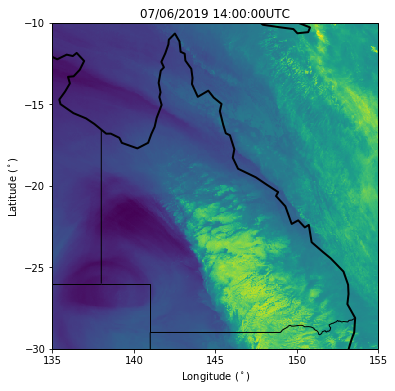

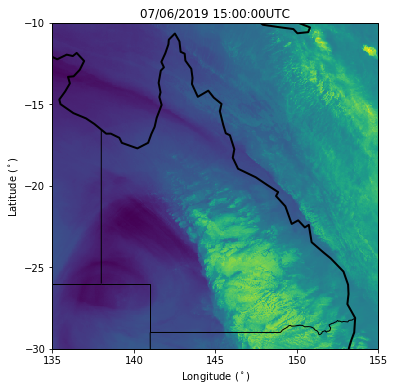

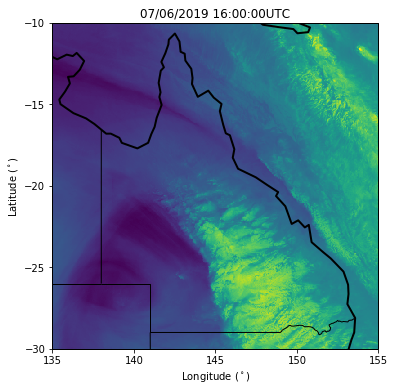

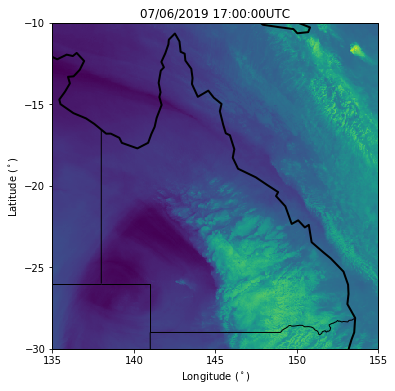

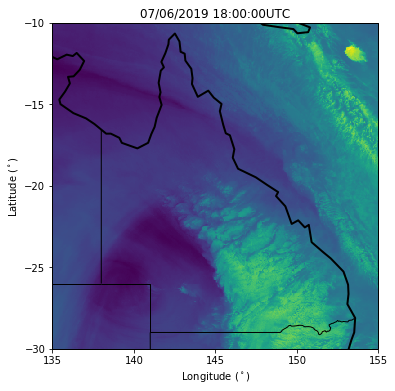

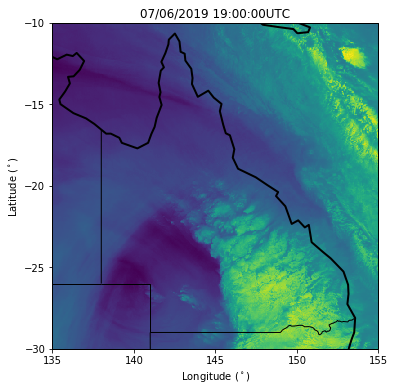

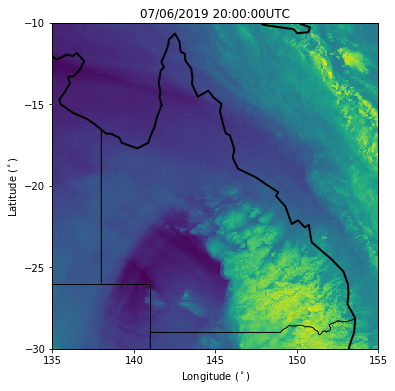

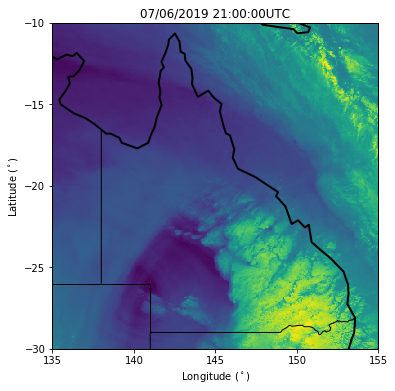

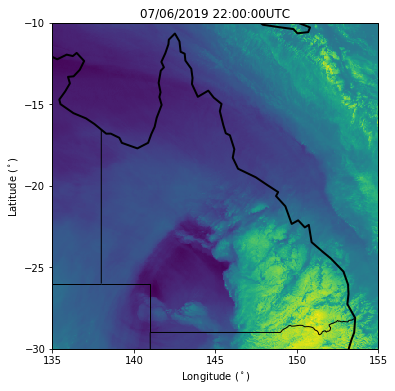

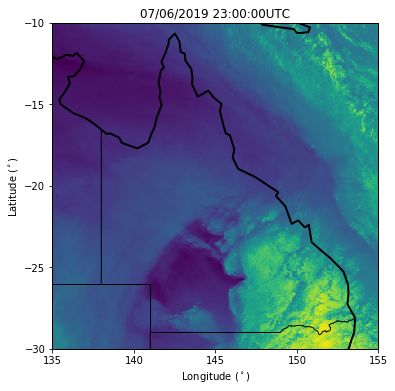

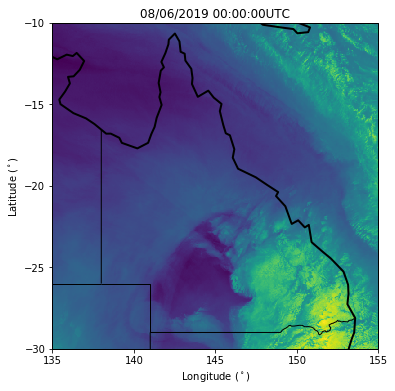

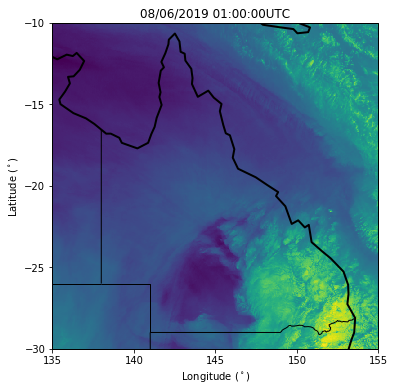

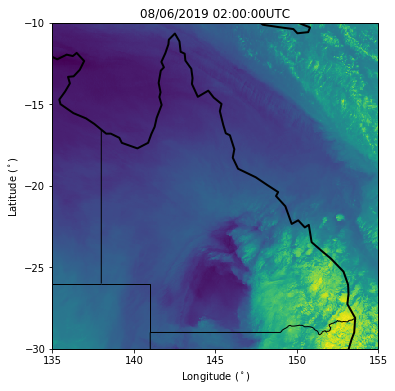

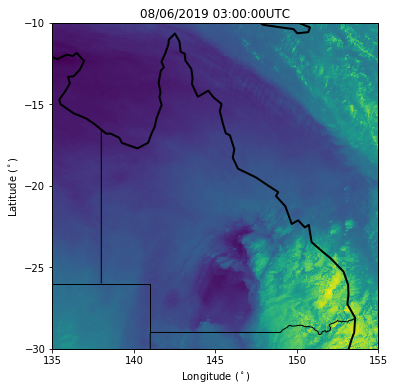

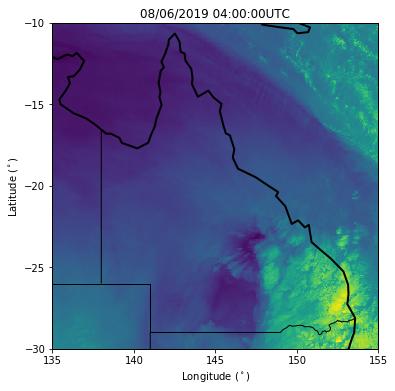

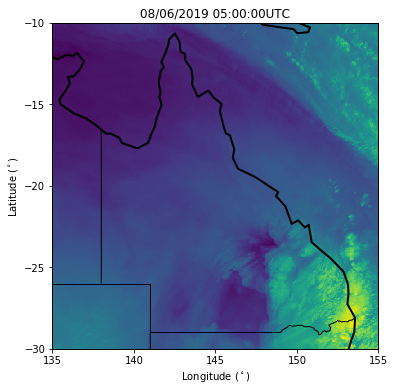

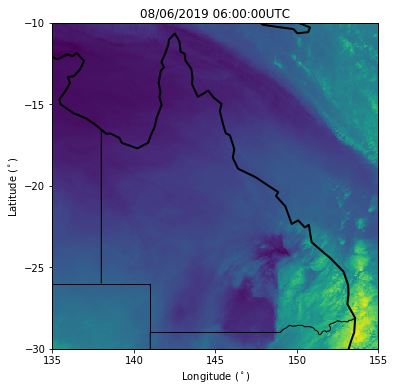

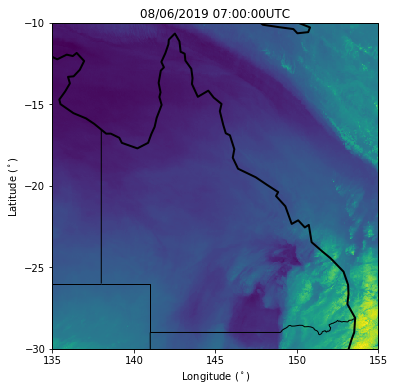

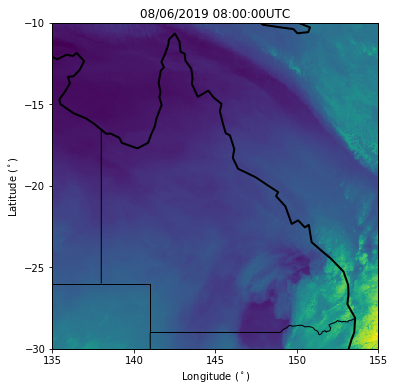

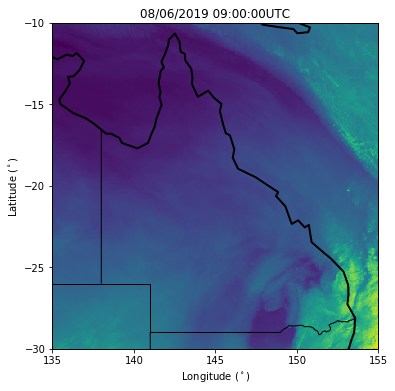

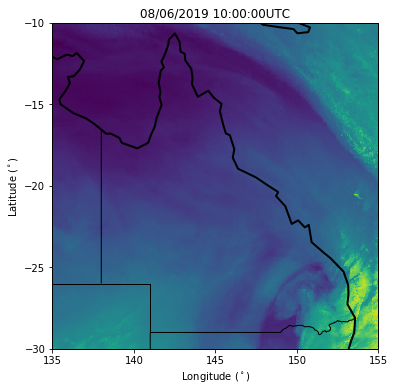

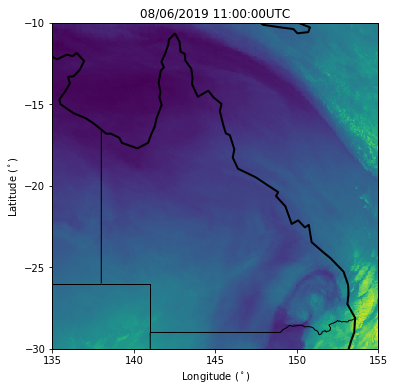

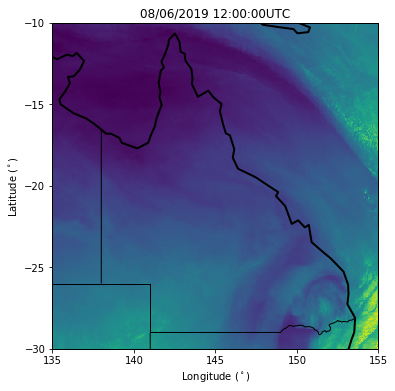

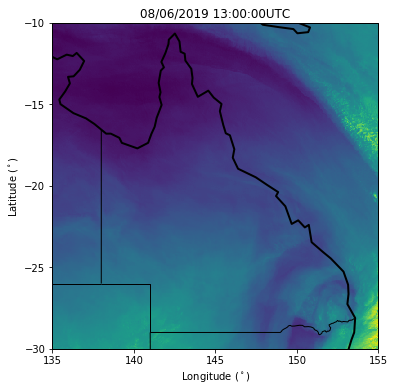

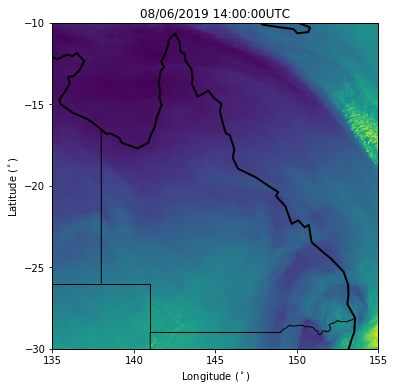

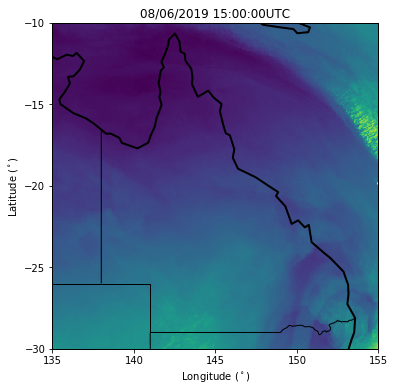

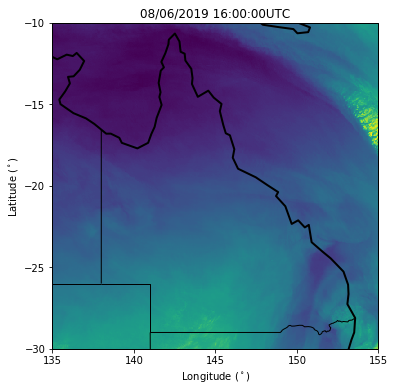

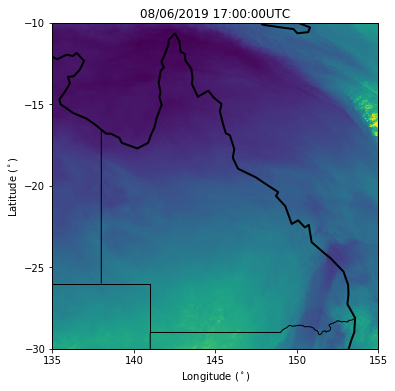

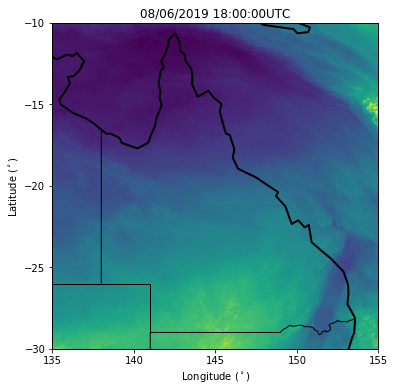

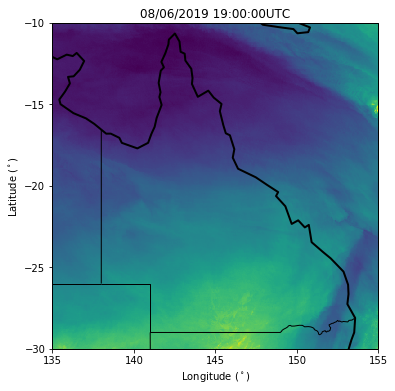

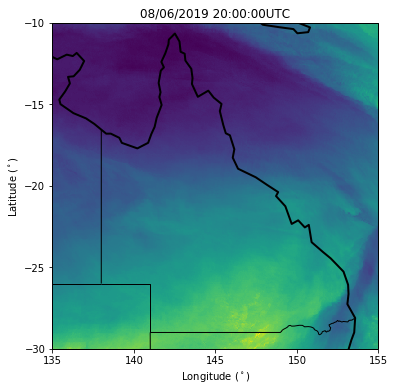

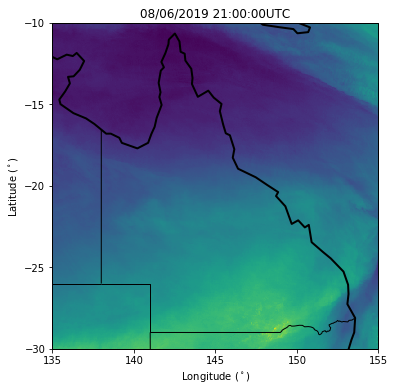

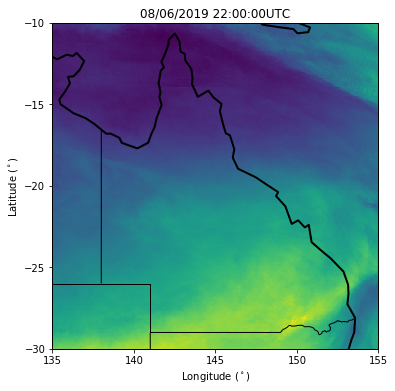

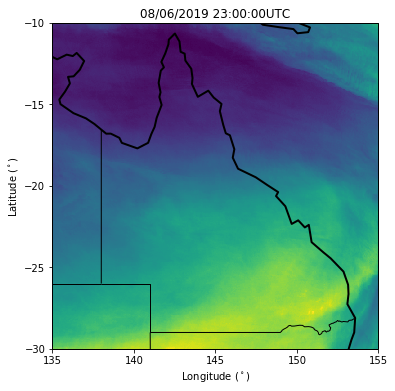

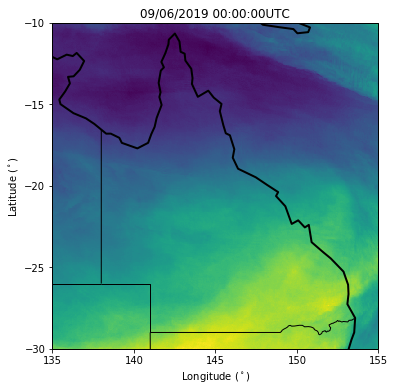

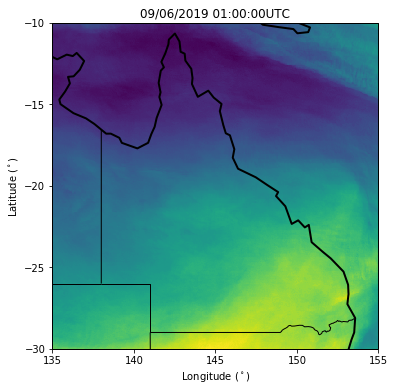

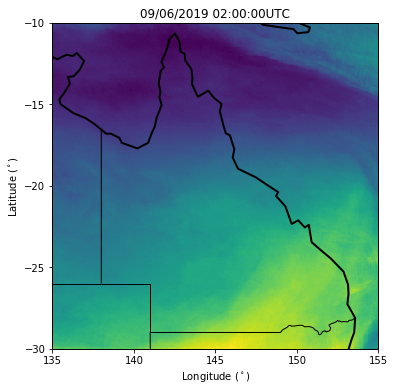

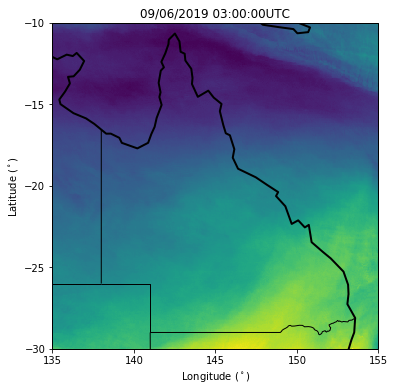

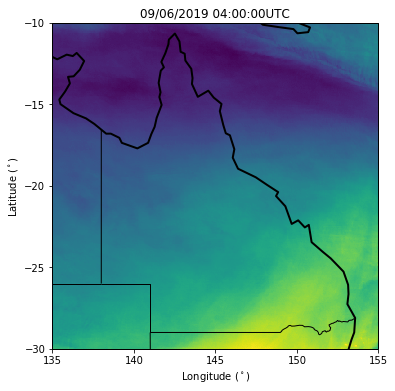

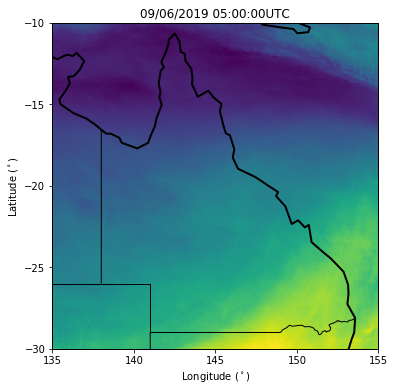

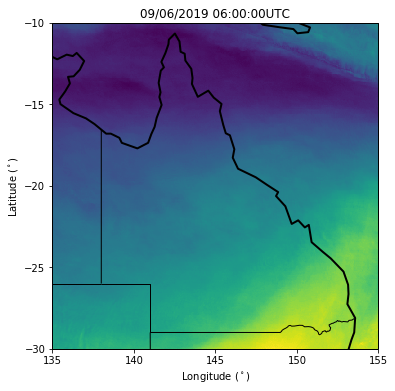

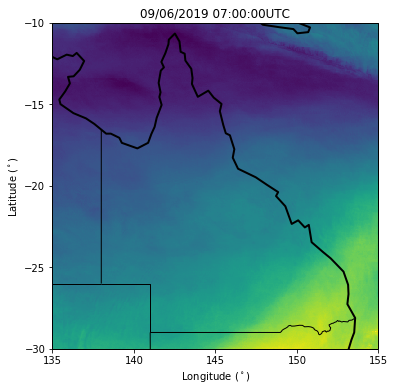

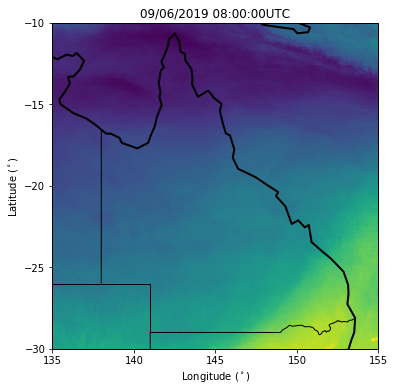

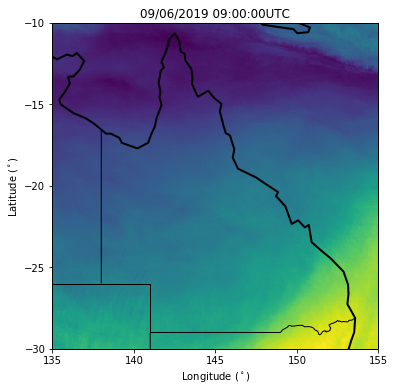

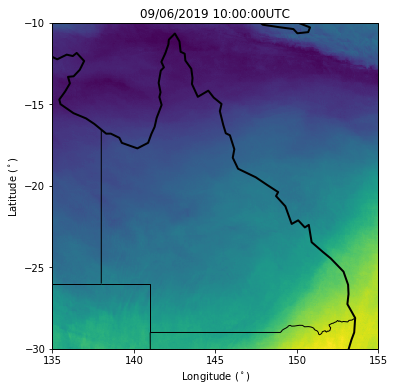

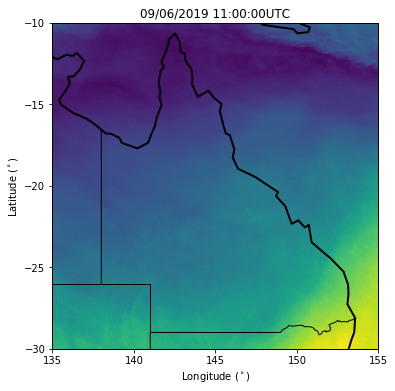

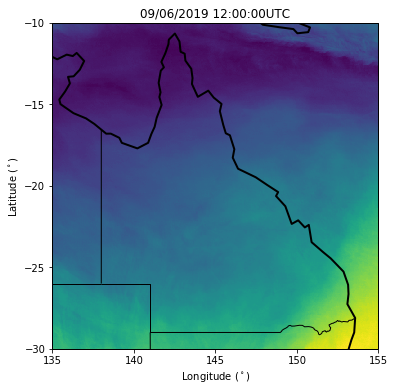

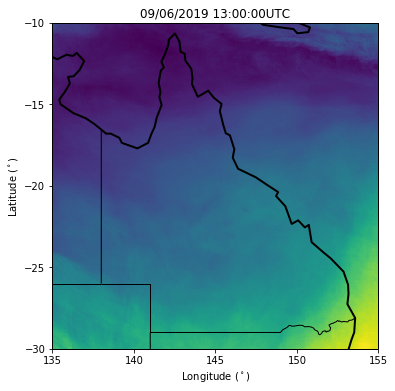

In [10]:
for ii,path in enumerate(paths):  
    print("Start %i, %s"%(ii,path))
    try:
        for jj in range(len(band_suffix)):
            src = gdal.Open(path + band_suffix[jj])
    
            dst = gdal.GetDriverByName('MEM').Create('', x_size, y_size, 1, gdal.GDT_Float32,)
            dst.GetRasterBand(1).WriteArray(np.zeros((y_size, x_size), dtype=np.float32))
            dst.SetGeoTransform(geot)
            dst.SetProjection(wgs84_wkt)
            dst.ReadAsArray().dtype
    
            err = gdal.ReprojectImage(src,dst,None,None,gdal.GRA_NearestNeighbour)

            arr = dst.ReadAsArray()
        
            if jj==0:
                arr_stack = arr.copy()
                arr_stack = np.expand_dims(arr_stack,axis=2)
       
            else:
                arr = np.expand_dims(arr,axis=2)
                arr_stack = np.append(arr_stack,arr,axis=2)
        # process rgb
        #print(arr_stack[:,:,[2,1,0]].min(),arr_stack[:,:,[2,1,0]].max())
        #rgb = np.clip(arr_stack[:,:,[2,1,0]],0,0.5) / 0.5 * 255
        #print(rgb.min(),rgb.max())
        #rgb = rgb.astype('uint8')
        #print(rgb.min(),rgb.max())
        #plotter(rgb,ii)
        #plt.savefig("qld_rgb/%04i.png"%ii)
        
        # process band 13
        b13 = arr_stack[:,:,3]
        plotter(b13,ii)
        plt.savefig("qld_b13/%04i.png"%ii)
        # plot and save png
        
        
    except ValueError:
        print("WARNING: data missing!")

In [12]:
rgb_dir = "qld_rgb"
b13_dir = "qld_b13"
png_dir = "qld_merged"

# resize image to cut off white space
!mogrify -extent 430x350 -gravity Center $rgb_dir/*.png
!mogrify -extent 430x350 -gravity Center $b13_dir/*.png

# append figures vertically
#!mkdir tas_merged
for i in range(len(t_range)):
    fname = "%04i.png"%i
    !convert -append $rgb_dir/$fname $b13_dir/$fname $png_dir/$fname

# make gif
!convert -delay 25 $png_dir/*.png -delay 200 $png_dir/$fname -loop 0 $png_dir.gif

convert: no decode delegate for this image format `/' @ error/constitute.c/ReadImage/532.
